# PURE Kinetics Analysis Tutorial

This tutorial guides you through analyzing time-series fluorescence data from PURE (Protein synthesis Using Recombinant Elements) cell-free expression experiments. We'll cover data loading, normalization, visualization, kinetic parameter fitting, and summary statistics.

## Table of Contents
1. [Setup and Import](#setup)
2. [Load Data](#load-data)
3. [Normalize Data](#normalize)
4. [Plot Raw Curves](#plot-curves)
5. [Kinetic Analysis](#kinetic-analysis)
6. [Summary Plots](#summary)

<!-- --- -->

## 1. Setup

First, import the necessary libraries and set up the plotting environment.

The custom `platereader` module that contains specialized functions for loading plate reader data, performing kinetic analysis, and visualization. The `plot_setup()` function configures matplotlib for time-series plots.

In [1]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import the cdk platereader module
from cdk.analysis.cytosol import platereader as pr

# Set up plotting
pr.plot_setup()

<!-- --- -->

## 2. Load Data

Load your plate reader data and merge it with the platemap that describes experimental conditions.

- `data_file` is the location of your platereader data (ideally in biotek-cdk format)
- `platemap_file`: location of your platemap CSV with Well and experimental conditions
- `load_platereader_data()` reads your plate reader output file and parses it into a standardized format with the platemap integrated
- The resulting DataFrame contains columns: `Well`, `Row`, `Column`, `Time`, `Seconds`, `Temperature (C)`, `Read`, `Data`, plus any columns from your platemap
- `Data` column contains fluorescence measurements (RFU - Relative Fluorescence Units)
- `Time` representing elapsed time

In [2]:
# Specify file paths
data_file = "sample-data/20251111-122213-cytation5-pure-timecourse-gfp-MFG-98-tRNA-QC-biotek-cdk.txt"
platemap_file = "sample-data/platemap.csv"


# Load data
data, platemap = pr.load_platereader_data(
    data_file=data_file,
    platemap_file=platemap_file,
    platereader="biotek-cdk"  # Options: "cytation", "envision", "biotek-cdk"
)

# Checkout first few rows
data.head()

,Time,Well,Data,Row,Column,Read,Plate,Clock Time,Date,Experiment Name,...,DNA ID,[DNA] (ng/uL),PMix Vol (uL),Ribosome Vol (uL),SMS Vol (uL),tRNA Vol (uL),DNA Vol (uL),RNase Inhib Vol (uL),Water vol (uL),Rxn Volume (uL)
0,0 days 00:00:33,B2,245,B,2,GFP-Gext,Plate 1,2025-11-11 12:24:37,11/11/2025,MFG-98-tRNA-QC,...,AR-805,120.00,3.00,NaN,3.00,1.00,0.50,0.50,2.00,10.00
1,0 days 00:05:33,B2,254,B,2,GFP-Gext,Plate 1,2025-11-11 12:29:37,11/11/2025,MFG-98-tRNA-QC,...,AR-805,120.00,3.00,NaN,3.00,1.00,0.50,0.50,2.00,10.00
2,0 days 00:10:33,B2,249,B,2,GFP-Gext,Plate 1,2025-11-11 12:34:37,11/11/2025,MFG-98-tRNA-QC,...,AR-805,120.00,3.00,NaN,3.00,1.00,0.50,0.50,2.00,10.00
3,0 days 00:15:33,B2,230,B,2,GFP-Gext,Plate 1,2025-11-11 12:39:37,11/11/2025,MFG-98-tRNA-QC,...,AR-805,120.00,3.00,NaN,3.00,1.00,0.50,0.50,2.00,10.00
4,0 days 00:20:33,B2,265,B,2,GFP-Gext,Plate 1,2025-11-11 12:44:37,11/11/2025,MFG-98-tRNA-QC,...,AR-805,120.00,3.00,NaN,3.00,1.00,0.50,0.50,2.00,10.00


<!-- --- -->

## 4. Plot Raw Curves

Visualize the time-series fluorescence data to inspect curve shapes and identify any issues.

- `plot_curves_by_name()` creates line plots with time on x-axis and fluorescence (Data) on y-axis
- Each line represents one well, colored by the `Name` column (experimental condition)
- If you have multiple gain data, they'll be plotted in separate subplots (but you should choose one to move forward with)
- This visualization helps you spot outliers, failed reactions, or unexpected kinetics before fitting

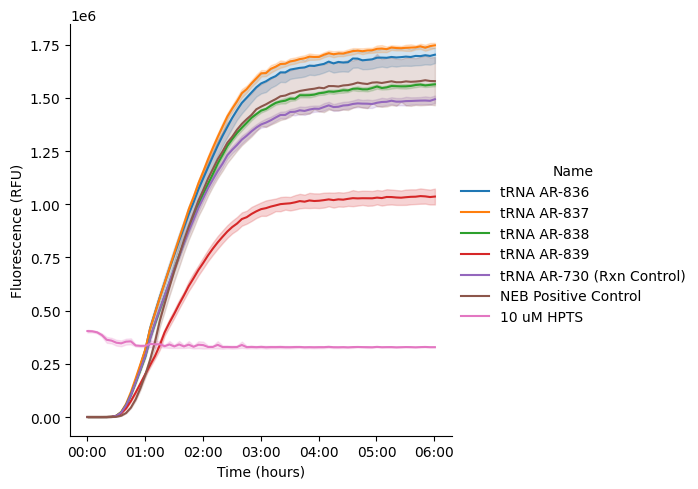

In [3]:
g = pr.plot_curves(data=data)

<!-- --- -->

## 3. Normalize Data

Normalize your data to an internal fluorescence sample so that you have relative fluorescence to compare to other experiments. 

In [4]:
data = pr.normalize_data_to_controls(data, ctrl_name = '10 uM HPTS')

Data Normalized to 10 uM HPTS in col data_normalized. The active column for subsequent operations is: data_normalized


Now replot your curves to see them normalized

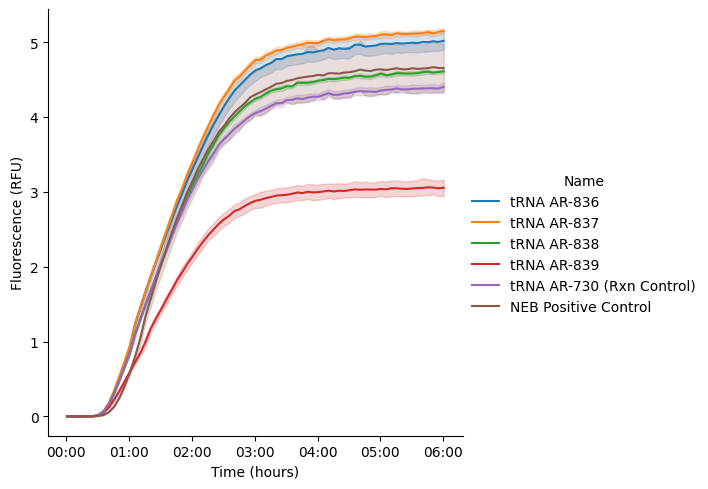

In [5]:
g = pr.plot_curves(data=data)

<!-- --- -->

## 5. Kinetic Analysis

Fit sigmoid curves to the data to extract kinetic parameters: maximum velocity (Vmax), lag time, steady-state level, and drift.

- `kinetic_analysis()` fits a **sigmoid curve** (with optional drift term) to each replicate well
- The model: $y(t) = \frac{L}{1 + e^{-k(t - t_0)}} + b(t - \tau)$
  - $L$: Steady-state level (asymptote)
  - $k$: Growth rate (steepness)
  - $t_0$: Inflection point (time of max velocity)
  - $b$: Drift rate (fluorescence change after steady-state)
  - $\tau$: Drift onset time
- **Metrics extracted:**
  - **Vmax** (`Velocity Max`): Maximum rate of fluorescence increase (slope at inflection point)
  - **Lag time**: Time to reach the exponential phase
  - **Steady-state**: Final fluorescence level and time to reach 95% of asymptote
  - **Drift**: Rate of signal decay or increase after steady-state
  - **R²**: Goodness of fit

In [6]:
# Perform kinetic analysis using sigmoid_drift model
kinetics = pr.kinetic_analysis(
    data=data,
    group_by=['Name'],  # Group by experimental condition
)

kinetics.head()

PROVIDING AVERAGED KINETICS


Velocity                       \
                                               Time data_normalized  Max   
Name                                                                       
NEB Positive Control      0 days 01:34:45.616715696            2.25 2.69   
tRNA AR-730 (Rxn Control) 0 days 01:29:01.540193308            2.19 2.34   
tRNA AR-836               0 days 01:31:43.799320428            2.52 2.56   
tRNA AR-837               0 days 01:32:27.273708334            2.58 2.66   
tRNA AR-838               0 days 01:31:47.921783514            2.31 2.41   

                                                Lag                  \
                                               Time data_normalized   
Name                                                                  
NEB Positive Control      0 days 00:44:28.688704778            0.30   
tRNA AR-730 (Rxn Control) 0 days 00:32:45.112764155            0.19   
tRNA AR-836               0 days 00:32:30.333969522            0.21   
tRNA AR-837               0 days 00:34:09.146983246            0.24   
tRNA AR-838               0 days 00:34:09.156125597            0.22   

                                       Steady State                  \
                                               Time data_normalized   
Name                                                                  
NEB Positive Control      0 days 02:48:47.196931504            4.28   
tRNA AR-730 (Rxn Control) 0 days 02:51:52.382459217            4.17   
tRNA AR-836               0 days 02:58:55.280264960            4.79   
tRNA AR-837               0 days 02:58:17.284049550            4.90   
tRNA AR-838               0 days 02:56:39.983994240            4.39   

                                                                         Fit  \
                                                                      params   
Name                                                                           
NEB Positive Control       [4.501773951041968, 2.3866385500131293, 1.5793...   
tRNA AR-730 (Rxn Control)  [4.384380953592719, 2.1324521783287356, 1.4837...   
tRNA AR-836                [5.0426505851597225, 2.0266336639016616, 1.528...   
tRNA AR-837                [5.161645765443068, 2.0583942112412883, 1.5409...   
tRNA AR-838                [4.622649794838434, 2.081776126751595, 1.52997...   

                                      
                           R^2 drift  
Name                                  
NEB Positive Control      1.00  0.08  
tRNA AR-730 (Rxn Control) 1.00  0.07  
tRNA AR-836               1.00  0.07  
tRNA AR-837               1.00  0.07  
tRNA AR-838               1.00  0.06

### Visualize Fits on Individual Wells

**What's happening:**
- `plot_kinetics_by_well()` overlays fitted curves and kinetic parameters on raw data
- Visual inspection ensures fits are reasonable (high R², smooth curves)
- Annotations show where Vmax, lag time, and steady-state occur

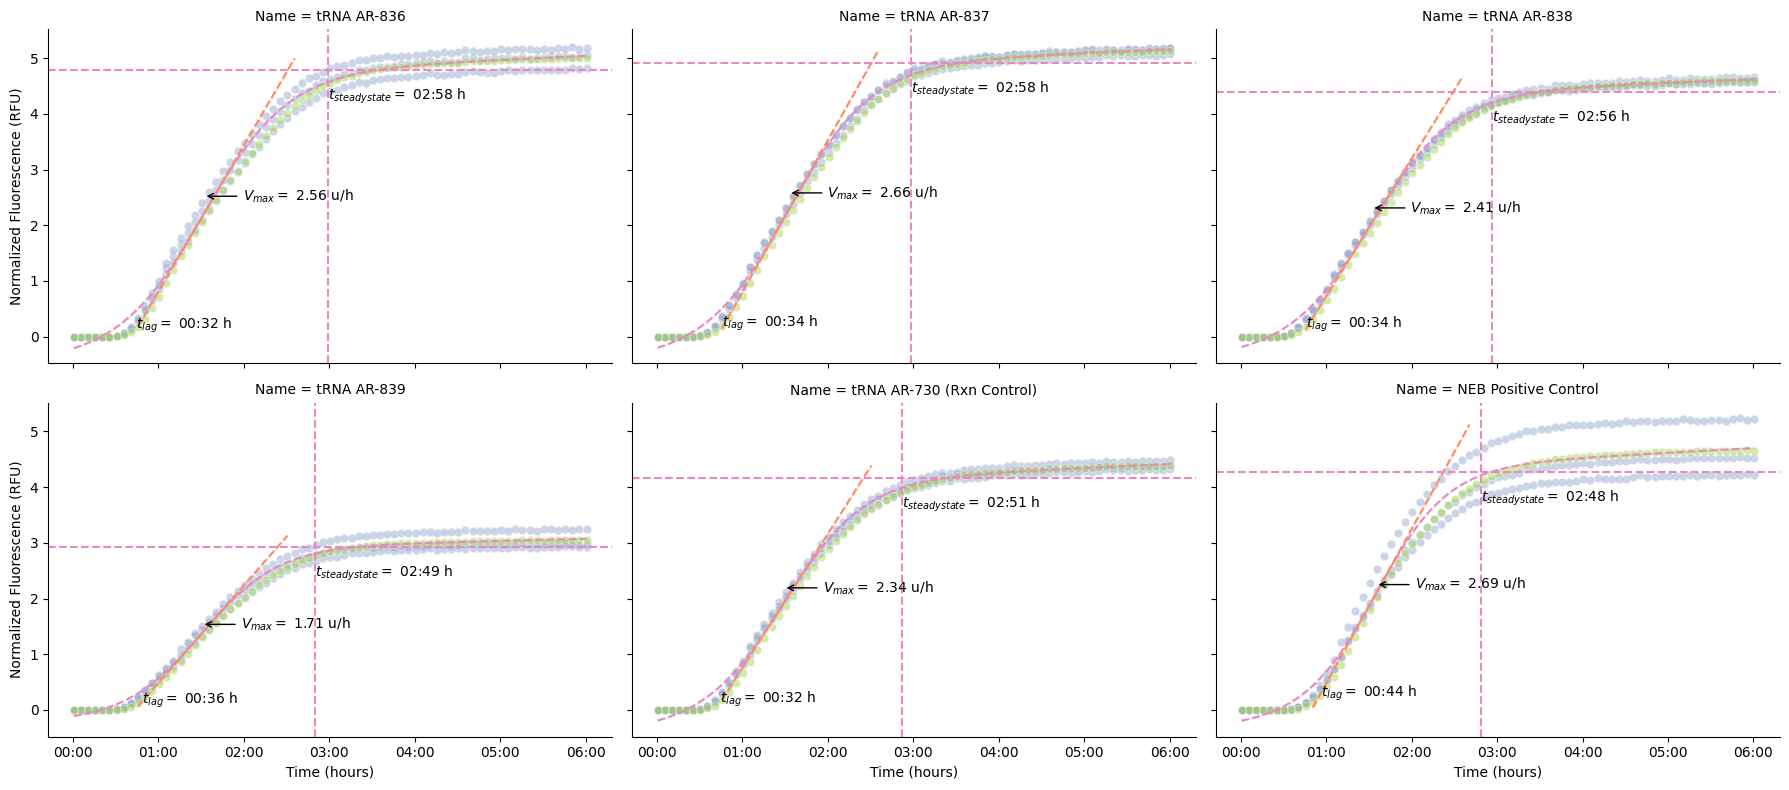

In [7]:
# Plot kinetic fits 
g, kinetics = pr.plot_kinetics(data, kinetics=kinetics, group_by=["Name"])

<!-- --- -->

## 6. Summary Plots

Compare kinetic parameters across experimental conditions.
- The `plot_kinetics_summary()` function creates a comprehensive multi-panel figure with raw curves, steady-state, Vmax, and drift
- Bar plots compare kinetic metrics across conditions
- **Steady-state:** Final protein expression level (proxy for yield)
- **Vmax:** Maximum rate of protein synthesis
- **Drift:** Signal stability (photobleaching, aggregation, continued synthesis...etc)
- Error bars show std across technical replicates

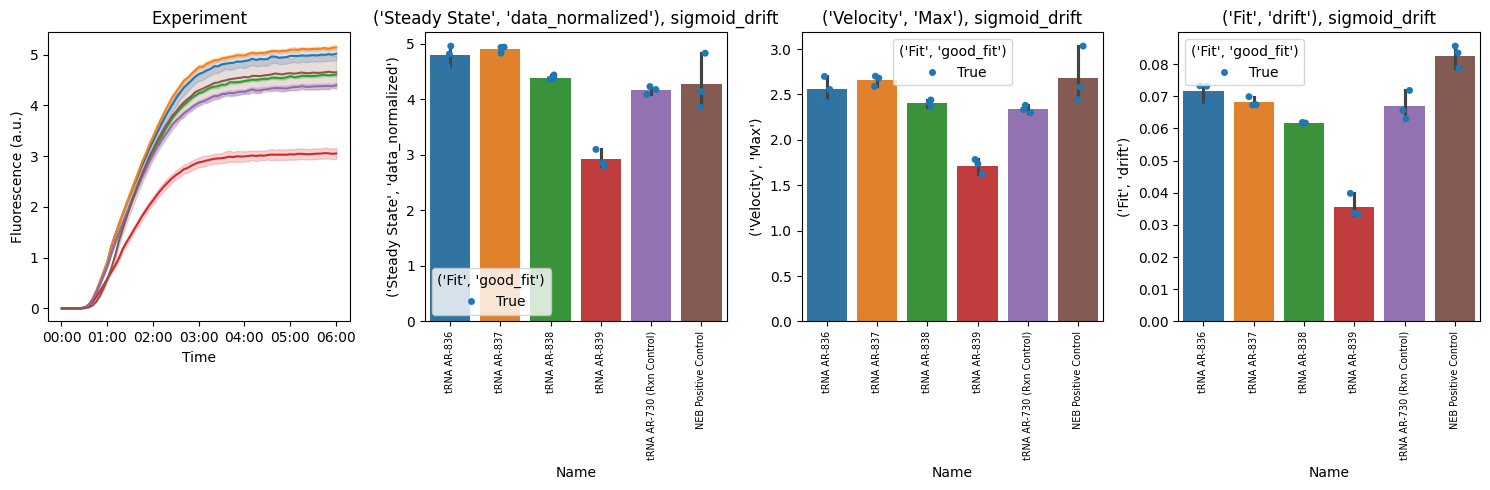

In [8]:
pr.plot_summary(data)

<!-- --- -->

## Key Metrics Explained

### 1. **Steady-State Level** (`Steady State, Data`)
- The final fluorescence value reached by the reaction
- Represents the total amount of protein produced
- Higher values indicate greater expression yield

### 2. **Maximum Velocity** (`Velocity, Max`)
- The steepest slope of the fluorescence curve (at the inflection point)
- Units: RFU per second
- Reflects the peak rate of protein synthesis
- Sensitive to enzyme activity, substrate availability, and reaction conditions

### 3. **Lag Time** (`Lag, Time`)
- Time before exponential fluorescence increase begins
- May reflect time for ribosome assembly or initial translation steps
- Shorter lag times suggest faster reaction initiation

### 4. **Drift** (`Fit, drift`)
- Rate of fluorescence change after reaching steady-state
- Positive drift: continued synthesis or aggregation
- Negative drift: photobleaching, protein degradation, or quenching
- Units: RFU per second

### 5. **R² Value** (`Fit, R^2`)
- Goodness of fit (0 to 1, higher is better)
- R² > 0.98 indicates excellent fit
- Poor fits may indicate noisy data, overflow errors, or non-sigmoid kinetics

<!-- --- -->

## Tips and Troubleshooting

- **Overflow errors:** Wells with `OVRFLW` or `NaN` values are automatically excluded from fitting
- **Poor fits (low R²):** Inspect raw curves for anomalies (bubbles, evaporation, pipetting errors)
- **Drift:** Sometimes seen in kinetics curves; use `sigmoid_drift` model
- **Multiple replicates:** Always include technical replicates and report error bars
- **Comparing conditions:** Normalize or blank data consistently across all samples

<!-- --- -->

## Next Steps

- Export kinetics results: `pr.export_kinetics(kinetics, 'results.csv')`
- Statistical analysis: Use `scipy.stats` or `statsmodels` for ANOVA/t-tests
- Parameter optimization: Vary Mg²⁺, K⁺, or other conditions to maximize Vmax or steady-state
- Mechanistic modeling: Fit ODE models to extract biological rate constants